# IMPORT LIBRIARIES

In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rainfall-in-india/rainfall in india 1901-2015.csv
/kaggle/input/rainfall-in-india/district wise rainfall normal.csv
/kaggle/input/carbon-emissions-and-population-from-1961-to-2015/carbon.csv
/kaggle/input/ecological-footprint/countries.csv


## Load carbon emission data

In [2]:
carb=pd.read_csv("/kaggle/input/carbon-emissions-and-population-from-1961-to-2015/carbon.csv")
carbon_data=carb[["Year","total_population","Avg_Carbon_emmsion_per capita","avg_temp_change"]]
carbon_data["total_population"]=carbon_data["total_population"].apply(pd.np.log)
carbon_data.head()

,Year,total_population,Avg_Carbon_emmsion_per capita,avg_temp_change
0,1961,24.159987,3.326700,0.144488
1,1962,24.177561,3.498224,-0.028981
2,1963,24.199008,3.946614,-0.026252
3,1964,24.220168,4.046382,-0.122131
4,1965,24.241396,4.067733,-0.224178


## Load weather Data

In [3]:
weather_data=pd.read_csv("/kaggle/input/rainfall-in-india/rainfall in india 1901-2015.csv")

## filter Year greater than 1960
weather_data=weather_data[weather_data["YEAR"]>1960]

## filter data based on Subdivision
weather_data=weather_data[weather_data["SUBDIVISION"]=='COASTAL KARNATAKA']

weather_data=weather_data.fillna(value=0)
weather_data.index=weather_data["YEAR"]
weather_data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
YEAR,,,,,,,,,,,,,,,,,,,
1961,COASTAL KARNATAKA,1961,0.0,0.0,0.9,47.7,635.0,1013.0,1884.9,936.3,702.8,309.6,21.0,2.7,5553.9,0.0,683.6,4536.9,333.4
1962,COASTAL KARNATAKA,1962,0.2,3.4,0.1,31.6,359.4,405.4,1307.9,1080.9,413.5,313.4,18.5,83.3,4017.7,3.6,391.1,3207.7,415.3
1963,COASTAL KARNATAKA,1963,1.1,0.7,28.6,38.5,86.0,682.3,887.6,1013.8,181.0,233.7,8.2,10.0,3171.3,1.8,153.0,2764.7,251.8
1964,COASTAL KARNATAKA,1964,0.0,0.0,2.6,5.8,23.4,631.7,864.0,978.1,363.9,200.2,53.1,17.6,3140.5,0.0,31.8,2837.8,271.0
1965,COASTAL KARNATAKA,1965,2.5,0.0,0.0,9.7,39.7,797.8,1002.5,577.2,196.8,25.1,20.1,159.8,2831.1,2.5,49.4,2574.2,205.0


### unstack data columns "Months" into roles

In [4]:
_data=weather_data[
    ['JAN',
     'FEB',
     'MAR',
     'APR',
     'MAY',
     'JUN',
     'JUL',
     'AUG',
     'SEP',
     'OCT',
     'NOV',
     'DEC']]
_data.columns=['01-JAN',
 '02-FEB',
 '03-MAR',
 '04-APR',
 '05-MAY',
 '06-JUN',
 '07-JUL',
 '08-AUG',
 '09-SEP',
 '10-OCT',
 '11-NOV',
 "12-DEC"]
_data=_data.unstack().reset_index(name="value")

### Merge the carbon and weather dataset

In [5]:
data=pd.merge(_data.sort_values(by=['YEAR','level_0']),carbon_data,left_on="YEAR",right_on="Year")[['level_0',
 'Year',"value",
 'total_population',
 'Avg_Carbon_emmsion_per capita',
 'avg_temp_change']]

# Data exploration

In [6]:
data.describe()

,Year,value,total_population,Avg_Carbon_emmsion_per capita,avg_temp_change
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,1988.000000,292.753939,24.665035,4.807058,0.404550
std,15.886548,406.887090,0.272639,0.631570,0.416684
min,1961.000000,0.000000,24.159987,3.326700,-0.224178
25%,1974.000000,3.700000,24.432779,4.413151,0.073026
50%,1988.000000,69.800000,24.692304,4.738343,0.281509
75%,2002.000000,496.275000,24.910377,5.203349,0.817206
max,2015.000000,1884.900000,25.077436,6.330283,1.326988


## data split

In [7]:
test_data=data[501:]
train_data=data[:501]

In [8]:
header=list(train_data.columns)
target="value"
header.remove(target)

## Hot Encode data

In [9]:
import category_encoders as ce
encoder=ce.OneHotEncoder()
encoder.fit(train_data[header],train_data[target])
transformed_train=encoder.transform(train_data[header])

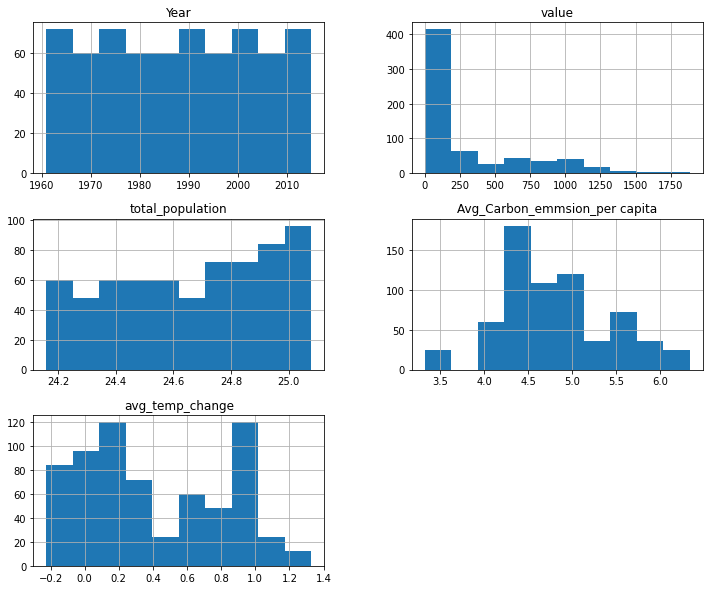

In [10]:
data.hist(figsize = (12,10))
plt.show()

# Neutral Network Model

In [11]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(32, kernel_initializer='normal',input_dim = transformed_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(16, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(8, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(4, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


## Save models

In [12]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

## Train Model

In [13]:
NN_model.fit(transformed_train, train_data[target], epochs=800, batch_size=12, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/800
34/34 [==============================] - 1s 21ms/step - loss: 316.5113 - mean_absolute_error: 316.5113 - val_loss: 310.4540 - val_mean_absolute_error: 310.4540

Epoch 00001: val_loss improved from inf to 310.45401, saving model to Weights-001--310.45401.hdf5
Epoch 2/800
34/34 [==============================] - 0s 3ms/step - loss: 286.9521 - mean_absolute_error: 286.9521 - val_loss: 304.1708 - val_mean_absolute_error: 304.1708

Epoch 00002: val_loss improved from 310.45401 to 304.17084, saving model to Weights-002--304.17084.hdf5
Epoch 3/800
34/34 [==============================] - 0s 3ms/step - loss: 296.3066 - mean_absolute_error: 296.3066 - val_loss: 296.9174 - val_mean_absolute_error: 296.9174

Epoch 00003: val_loss improved from 304.17084 to 296.91739, saving model to Weights-003--296.91739.hdf5
Epoch 4/800
34/34 [==============================] - 0s 3ms/step - loss: 294.5653 - mean_absolute_error: 294.5653 - val_loss: 296.7915 - val_mean_absolute_error: 296.7915

Epoch

## Download weights

In [14]:
from IPython.display import FileLinks
FileLinks(".")

./
  Weights-109--295.61545.hdf5
  Weights-702--81.63277.hdf5
  Weights-769--80.92055.hdf5
  Weights-128--295.05219.hdf5
  Weights-186--147.75583.hdf5
  Weights-005--296.41968.hdf5
  Weights-360--82.89277.hdf5
  Weights-744--80.95625.hdf5
  Weights-138--294.83621.hdf5
  Weights-192--135.12889.hdf5
  Weights-174--229.06662.hdf5
  Weights-182--151.24167.hdf5
  Weights-250--84.98959.hdf5
  Weights-142--294.39661.hdf5
  Weights-141--294.57779.hdf5
  Weights-176--200.77539.hdf5
  Weights-211--94.23705.hdf5
  Weights-164--286.77109.hdf5
  Weights-166--283.96942.hdf5
  Weights-203--106.69475.hdf5
  Weights-207--100.59306.hdf5
  Weights-451--82.30659.hdf5
  Weights-155--292.45490.hdf5
  Weights-242--86.28038.hdf5
  Weights-150--293.55978.hdf5
  Weights-135--294.85776.hdf5
  Weights-095--295.72919.hdf5
  Weights-175--216.37762.hdf5
  Weights-213--93.47688.hdf5
  Weights-224--87.84064.hdf5
  Weights-190--137.05977.hdf5
  Weights-004--296.79150.hdf5
  Weights-123--295.33878.hdf5
  Weights-325--83.80766.hdf5
  Weights-171--260.77451.hdf5
  Weights-201--111.85841.hdf5
  Weights-072--295.79980.hdf5
  Weights-001--310.45401.hdf5
  Weights-140--294.82431.hdf5
  Weights-217--90.55016.hdf5
  Weights-015--296.40125.hdf5
  Weights-121--295.39203.hdf5
  Weights-180--168.69177.hdf5
  Weights-119--295.60522.hdf5
  Weights-202--108.76903.hdf5
  Weights-152--292.97659.hdf5
  Weights-165--285.21451.hdf5
  Weights-132--294.88501.hdf5
  Weights-160--290.23260.hdf5
  Weights-195--122.47340.hdf5
  Weights-179--179.04169.hdf5
  Weights-169--275.19266.hdf5
  Weights-144--294.28934.hdf5
  Weights-168--277.90607.hdf5
  __notebook__.ipynb
  Weights-158--291.33389.hdf5
  Weights-172--252.97945.hdf5
  Weights-665--82.25240.hdf5
  Weights-200--113.03587.hdf5
  Weights-205--106.19810.hdf5
  Weights-167--281.20425.hdf5
  Weights-156--292.23108.hdf5
  Weights-146--293.96539.hdf5
  Weights-170--273.65424.hdf5
  Weights-003--296.91739.hdf5
  Weights-161--290.10574.hdf5
  Weights-181--162.32529.hdf5
  Weights-197--117.22186.hdf5
  Weights-120--295.42389.hdf5
  Weights-002--304.17084.hdf5
  Weights-194--124.88021.hdf5
  Weights-021--296.02231.hdf5
  Weights-189--142.96550.hdf5
  Weights-177--182.94916.hdf5
  Weights-162--288.53482.hdf5
  Weights-196--119.29538.hdf5
  Weights-255--84.38518.hdf5

# Predict  this month's  rainfall

In [15]:
NN_model.predict(np.array([[0,0	,0,	0,	0,	0,	1,	0,	0,	0,	0,	0,	2021,	24.910377,	4.621587,	0.926928]]))[0][0]

1150.4938

# Predict  Next month's  rainfall

In [16]:
NN_model.predict(np.array([[0,0 ,0, 0,  0,  0,  0,  1,  0,  0,  0,  0,  2021,   24.910377,  4.621587,   0.926928]]))[0][0]

843.2584